# Multi Layer Perceptron

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
import os
from src.dataPipeline import DataPipeline


os.chdir('..')

imputer = KNNImputer(n_neighbors=5)
dp = DataPipeline()
df = dp.runPipeline(normalizeAndStandardize=False, basic_house_imputer=True, imputer=imputer)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:45: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

In [2]:
inputs_nums = len(df.columns) - 1
print(f'input nums: {inputs_nums}')

input nums: 153


In [3]:
df

,Floor,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,...,region_group_40,region_group_41,region_group_42,region_group_43,region_group_44,region_group_45,region_group_46,region_group_47,region_group_48,region_group_49
0,4.0,0.511176,0.286451,0.090908,0.000000,0.000000,0.000000,0.058298,0.067048,0.103850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.511176,0.286451,0.090908,0.000000,0.000000,0.000000,0.058298,0.067048,0.103850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.163362,0.095877,0.001911,0.000000,0.000000,0.000000,0.334957,0.381257,0.297575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.511176,0.286451,0.090908,0.000000,0.000000,0.000000,0.058298,0.067048,0.103850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.333865,0.279276,0.145835,0.000000,0.000000,0.000000,0.133498,0.132933,0.235917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476,0.0,0.495715,0.385885,0.097278,0.000000,0.000000,0.000000,0.236514,0.333301,0.404824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22477,1.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.325610,0.384754,0.473527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22478,0.0,0.000000,0.000000,0.000000,0.052609,0.083575,0.027766,0.306761,0.311963,0.249603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22479,0.8,0.410843,0.151363,0.038351,0.000000,0.000000,0.000000,0.198066,0.269398,0.306468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
from src import torchModelRun
import torch
import torch.nn as nn
import torch.nn.functional as F

inputs_nums = len(df.columns) - 1

class FullyConnectedModel(nn.Module):
    import torch.nn.functional as F
    def __init__(self):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(inputs_nums, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    

models = torchModelRun.run(FullyConnectedModel, df, 4)

Epoch 1, Loss: 7.564298032624316, Train MAPE: 71.65832618661977, Test MAPE: 88.9227806017949
Epoch 2, Loss: 0.40936919299597, Train MAPE: 62.977484261565074, Test MAPE: 54.394035786848804
Epoch 3, Loss: 0.293204377662602, Train MAPE: 45.366987583611994, Test MAPE: 53.01071020273062
Epoch 4, Loss: 0.257777081348927, Train MAPE: 6000.451669433234, Test MAPE: 51.69913988113403
Epoch 5, Loss: 0.22868211564892066, Train MAPE: 75.6402254719592, Test MAPE: 55.01588702568641
Epoch 6, Loss: 0.19894104756422062, Train MAPE: 33.12465488554998, Test MAPE: 39.077989790989804
Epoch 7, Loss: 0.17909800248889252, Train MAPE: 31.4784502693962, Test MAPE: 37.63111620682936
Epoch 8, Loss: 0.16727307574380695, Train MAPE: 31.13041694813674, Test MAPE: 37.58206839194665
Epoch 9, Loss: 0.15813035046981147, Train MAPE: 30.52576920341367, Test MAPE: 36.535824394226076
Epoch 10, Loss: 0.15008135665749506, Train MAPE: 29.86369902727349, Test MAPE: 36.145774364471436
Epoch 11, Loss: 0.14412436048079844, Train MA

test_loss,█▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_mape,█▃▂█▃▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time_test,▃▃▄█▃▂▄▃▃▆▂▂▁▁▃▄▄▄▁▃▇▆▅▇▆▁▂▁▁▂▂▂▁▂▃▂▂▂▃▃
time_train,▃▂▂▇▃▃▃▄▃▂▄▂▂▁▄▃█▇▆▄▅▄▃▁▂▂▁▂▂▂▃▂▃▂▂▂▂▃▂▂
train_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mape,█▇▇▆▅▄▄▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.15184
test_mape,28.73717
time_test,1.67869
time_train,2.691
train_loss,0.06609


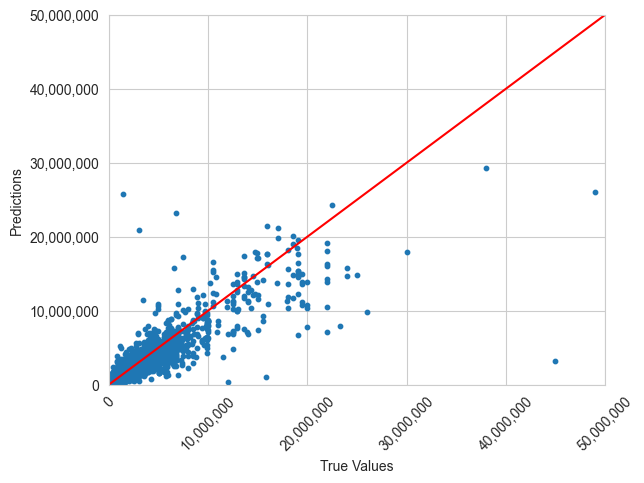

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

largest_num = 5e+7
transformer = models[0]['transform']
model = models[0]['model']
model.eval()
model = model.to('cpu')

df_exclude = df.drop(columns=['price_cleaned'])
df_exclude_np = df_exclude.values
input = transformer(torch.tensor(df_exclude_np, dtype=torch.float32))
output = model(input)
#output_cliped = torch.clamp(output, 6.0, 18.0)
output = torch.exp(output)

plt.scatter(df['price_cleaned'], output.detach().numpy(), s=10, alpha=1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.ylim([0, largest_num])
plt.xlim([0, largest_num])
plt.plot([0, largest_num], [0, largest_num], color='red')

# Set the axes to display whole numbers
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# rotate the x-axis labels
plt.xticks(rotation=45)

plt.show()

In [7]:
# Print model summary
print(models[0]['model'])


FullyConnectedModel(
  (fc1): Linear(in_features=153, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
)


In [8]:
import torch

trues = torch.tensor(df['price_cleaned'].values, dtype=torch.float32)


print(f'min outputs: {torch.min(output).item():.4f}, max outputs: {torch.max(output).item():.4f}')
# Berechnung des R^2-Werts
ss_res = torch.sum((trues - output) ** 2)
ss_tot = torch.sum((trues - torch.mean(trues)) ** 2)

print(f"ss_res: {ss_res.item():.4f}, ss_tot: {ss_tot.item():.4f}")

r2_score = 1 - (ss_res / ss_tot)  # R^2-Formel
print(f"R^2-Wert: {r2_score.item():.4f}")

min outputs: 64927.5938, max outputs: 29237530.0000
ss_res: 2209280766653289725952.0000, ss_tot: 61173833377251328.0000
R^2-Wert: -36113.8008


In [9]:
# get index of max prediction to get original data
index = torch.argmax(output)

print(f'index: {index}, max value: {output[index].item():.0f}')
df.iloc[[int(index)]]

index: 12543, max value: 29237530


,Floor,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,...,region_group_40,region_group_41,region_group_42,region_group_43,region_group_44,region_group_45,region_group_46,region_group_47,region_group_48,region_group_49
13958,0.0,0.029699,0.001037,0.0,0.044208,0.0,0.0,0.172486,0.127921,0.174566,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# store model for later use
torch.save(models[0]['model'], 'model.pt')

#store transformer for later use
torch.save(models[0]['transform'], 'transformer.pt')